# Fiber Bundle Representations

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Concatenate, Dense, Input
from tensorflow.keras.optimizers import RMSprop

In [3]:
%load_ext tikzmagic

This notebook examines Fiber Bundles as State Representations. At a high level, fiber bundle state representations attempt to model the state $\mathcal{X}$ of a reinforcement learning task with action space $\mathcal{A}$, reward $\rho : \mathcal{X} \times \mathcal{A} \to \mathbf{R}$, and transition $P: \mathcal{X} \times \mathcal{A} \to \mathcal{X}$ through a fiber bundle of $\mathcal{X}$ over task-relevant information $\mathcal{S}$ and task-irrelevant information $\mathcal{W}$ manifolds, such that the reward and transition factor through $\mathcal{S}$ as illustrated below.

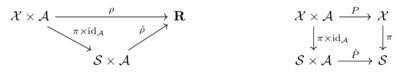

In [4]:
%%tikz -p amsmath -p tikz-cd

\draw node at (0, 0){
    \begin{tikzcd}
        \mathcal{X} \times \mathcal{A} \arrow[rr, "\rho"] \arrow[dr, "\pi \times \mathrm{id}_\mathcal{A}"] & & \mathbf{R} & & & \mathcal{X} \times \mathcal{A} \arrow[r, "P"] \arrow[d, "\pi \times \mathrm{id}_\mathcal{A}"] &  \mathcal{X} \arrow[d, "\pi"] \\
        & \mathcal{S} \times \mathcal{A} \arrow[ur, "\hat{\rho}"] & & & & \mathcal{S} \times \mathcal{A} \arrow[r, "\hat{P}"] & \mathcal{S}
    \end{tikzcd}
};

Fiber bundles attempt to form the state representation by implicitly learning the fiber bundle, its submersions onto $\mathcal{S}$ and $\mathcal{W}$, and the lift from both back to $\mathcal{X}$ by constructing approximation manifolds $\mathcal{S}_\phi$ and $\mathcal{W}_\phi$ dictated by $\phi : \mathcal{X} \to \mathcal{S}_\phi$ and $\omega_\phi : \mathcal{X} \to \mathcal{W}_\phi$.

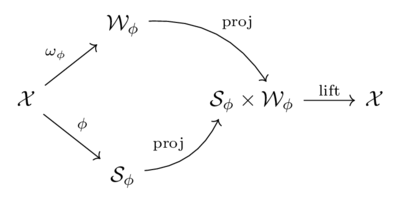

In [5]:
%%tikz -p amsmath -p tikz-cd

\draw node at (0, 0){
    \begin{tikzcd}
        & \mathcal{W}_\phi \arrow[dr, "\mathrm{proj}", end anchor={[xshift=-4ex,yshift=2ex]east}, bend left]\\
    \mathcal{X} \arrow[ur, "\omega_\phi"] \arrow[dr, "\phi"] & & \mathcal{S}_\phi \times \mathcal{W}_\phi \rar{\mathrm{lift}} & \mathcal{X} \\
        & \mathcal{S}_\phi \arrow[ur, "\mathrm{proj}", bend right, end anchor={[xshift=2ex, yshift=-2ex]west}]
    \end{tikzcd}
};

We prove that if such $\mathcal{S}$ exists, then it is unique up to isometry. From this property, we can derive several loss functions which when minimized would produce $\mathcal{S} \simeq \mathcal{S}_\phi$. We cover the first of these, based on [Plan2Vec](https://arxiv.org/pdf/2005.03648.pdf) below.

## Bundle Representation Plan2Vec Loss

In [6]:
from bundle_arch import BRepPlan2VecEstimator

We begin with an elementary example where $\mathcal{X} = \mathbf{R}^2$ and $\mathcal{S}$ is the first coordinate and $\mathcal{W}$ is the second coordinate. We construct the following simple Tensorflow model to illustrate the Bundle Representatino loss.

In [7]:
## First we must define the distance functions on both X and S
def simple_rep_dist(self, x1, x2):
    """The desired representation distance for test_simple (l2)
    Arguments:
        x1: a tf tensor
        x2: a tf tensor of the same shape as x1
    """
    return tf.math.sqrt(
        tf.math.reduce_sum(tf.math.square(x1[:, 0] - x2[:, 0]), axis=1))

def simple_input_dist(self, x1, x2):
    """The desired input distance for test_simple (l2)
    Arguments:
        x1: a tf tensor
        x2: a tf tensor of the same shape as x1
    """
    return tf.math.sqrt(tf.math.reduce_sum(tf.math.square(x1 - x2),
                                           axis=1))

In [8]:
## Now we define our desired architecture
inp = Input(shape=(2,), name='X')
rep = Dense(1, activation='relu', name='S')(inp)  # want first
fiber = Dense(1, activation='relu', name='W')(inp)  # want second
rep_inp = Input(shape=(1,), name='S_out')
fiber_inp = Input(shape=(1,), name='W_out')
con = Concatenate(name='SxW')([rep_inp, fiber_inp])
hid2 = Dense(2, activation='relu', name='lift')(con)  # want identity
outp = Dense(2, activation='relu', name='Xreconstr')(hid2)

rep_model = tf.keras.Model(inputs=inp, outputs=rep, name='rep')
fiber_model = tf.keras.Model(inputs=inp, outputs=fiber, name='fiber')
reconstr_model = tf.keras.Model(inputs=[rep_inp, fiber_inp],
                                outputs=[outp], name='reconstr')
reconstr_model.compile(loss=keras.losses.mean_squared_error,
                       optimizer=RMSprop())

model = BRepPlan2VecEstimator(rep_model=rep_model,
                              fiber_model=fiber_model,
                              reconstr_model=reconstr_model,
                              rep_dist=simple_rep_dist,
                              input_dist=simple_input_dist,
                              loss_w=1, optimizer=RMSprop(),
                              epochs=1, batch_size=100)

Let's compare the data flow graphs of the train model and test model:

In [9]:
%load_ext tensorboard
%env PATH=../../../env/bin:$PATH
import datetime

env: PATH=../../../env/bin:$PATH


In [10]:
# Define the training data (note that distances are implicit previously)
X = np.array([[x1, x2]
              for x1 in np.linspace(0, 1, 10)
              for x2 in np.linspace(0, 1, 10)]).reshape(100, 2)

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# With the given setup, then the trained model should be able to
# reconstruct the input and rep = inp[0] and fiber = inp[1]
tf.random.set_seed(0)
model.fit(X, verbose=1, callbacks=[tensorboard_callback])

99/99 [==============================] - 0s 2ms/step - loss: 0.1184 - reconstr_loss: 0.1184 - reconstruction_loss: 0.0000e+00 - bundle_representation_loss: 0.0000e+00


/home/liam/harvard/research/bundle-rep/github/bundle-rep/env/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


BRepPlan2VecEstimator(batch_size=100, epochs=1,
                      fiber_model=<tensorflow.python.keras.engine.training.Model object at 0x7f7ae426e4a8>,
                      input_dist=<function simple_input_dist at 0x7f7ae45269d8>,
                      loss_w=1,
                      optimizer=<tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7f7ae42cd588>,
                      reconstr_model=<tensorflow.python.keras.engine.training.Model object at 0x7f7ae42183c8>,
                      rep_dist=<function simple_rep_dist at 0x7f7ae4526950>,
                      rep_model=<tensorflow.python.keras.engine.training.Model object at 0x7f7ae42cdfd0>)

In [11]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 4480), started 0:09:43 ago. (Use '!kill 4480' to kill it.)